### Integrated-gradient for image classification (Tensorflow)

This is an example of the integrated-gradient method on image classification with a Tensorflow model. If using this explainer, please cite the original work: https://github.com/ankurtaly/Integrated-Gradients.

In [1]:
# This default renderer is used for sphinx docs only. Please delete this cell in IPython.
import plotly.io as pio
pio.renderers.default = "png"

In [2]:
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import mobilenet_v2
from PIL import Image as PilImage

from omnixai.data.image import Image
from omnixai.preprocessing.image import Resize
from omnixai.explainers.vision import IntegratedGradientImage

We recommend using `Image` to represent a batch of images. `Image` can be constructed from a numpy array or a Pillow image. The following code loads one test image and resizes them to (224, 224).

In [3]:
# Load the test image
img = Resize((224, 224)).transform(Image(PilImage.open('../data/images/dog_cat_2.png').convert('RGB')))
# Load the class names
with open('../data/images/imagenet_class_index.json', 'r') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

In this example, we apply a MobileNetV2 model for image classification.

In [4]:
model = mobilenet_v2.MobileNetV2(include_top=True, weights='imagenet', classes=1000)

The preprocessing function takes an `Image` instance as its input and outputs the processed features that the ML model consumes. In this example, each image in the `Image` object is transformed via `tf.keras.preprocessing.image.img_to_array` followed by `mobilenet_v2.preprocess_input`.

In [5]:
def preprocess(images):
    data = []
    for i in range(len(images)):
        im = tf.keras.preprocessing.image.img_to_array(images[i].to_pil())
        data.append(np.expand_dims(im, axis=0))
    data = np.concatenate(data, axis=0)
    mobilenet_v2.preprocess_input(data)
    return data

Let's check the predicted labels of this test image.

In [6]:
predictions = model.predict(preprocess(img))
top_indices = np.argsort(predictions)[0, ::-1][:5]
r = tuple((i, idx2label[i]) for i in top_indices)
print(r)

((243, 'bull_mastiff'), (242, 'boxer'), (282, 'tiger_cat'), (281, 'tabby'), (292, 'tiger'))


To initialize `IntegratedGradientImage`, we need to set the following parameters:

  - `model`: The ML model to explain, e.g., `tf.keras.Model` or `torch.nn.Module`.
  - `preprocess`: The preprocessing function converting the raw data (a `Image` instance) into the inputs of `model`.
  - `mode`: The task type, e.g., "classification" or "regression".

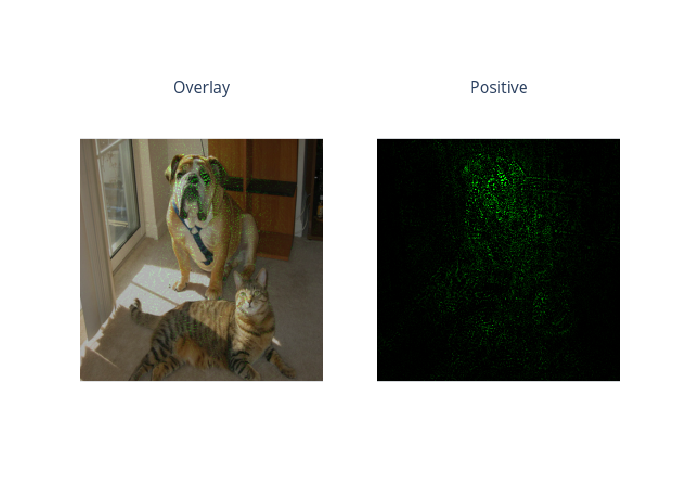

In [7]:
explainer = IntegratedGradientImage(
    model=model,
    preprocess_function=preprocess
)
# Explain the top label
explanations = explainer.explain(img)
explanations.ipython_plot(class_names=idx2label)

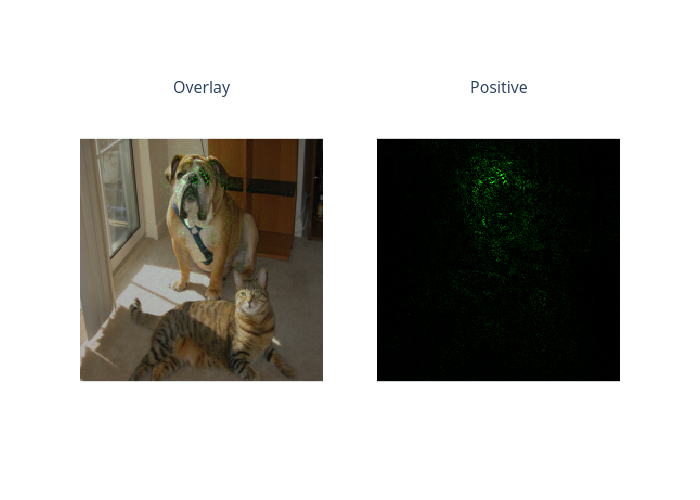

In [10]:
# Explain another label
explanations = explainer.explain(img, y=[242])
explanations.ipython_plot(class_names=idx2label)